In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
class NN(nt.NeuralNetwork):
    def __init__(self):
        super(NN, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [4]:
vgg = tv.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/xdg-cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 61.7MB/s] 


In [5]:
# Define the VGG network with transfer learning
class VGG19Transfer(NN):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGG19Transfer, self).__init__()
        vgg = tv.models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        # Only maintain the feature space    
        self.net = nn.ModuleList()
        self.net = vgg.features
        # Change MaxPool to AvgPool
        self.net[4] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[9] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[18] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[27] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[36] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
 
    def forward(self, x):
        rep = {}
        rep['c11'] = self.net[0](x)
        rep['r11'] = F.relu(rep['c11'] )
        rep['c12'] = self.net[2](rep['r11'] )
        rep['r12'] = F.relu(rep['r11'] )
        rep['p1'] = self.net[4](rep['c12'] )
        rep['c21'] = self.net[5](rep['p1'] )
        rep['r21'] = F.relu(rep['c21'] )
        rep['c22'] = self.net[7](rep['r21'] )
        rep['r22'] = F.relu(rep['c22'] )
        rep['p2'] = self.net[9](rep['r22'] )
        rep['c31'] = self.net[10](rep['p2'] )
        rep['r31'] = F.relu(rep['c31'] )
        rep['c32'] = self.net[12](rep['r31'] )
        rep['r32'] = F.relu(rep['c32'] )
        rep['c33'] = self.net[14](rep['r32'] )
        rep['r33'] = F.relu(rep['c33'] )
        rep['c34'] = self.net[16](rep['r33'] )
        rep['r34'] = F.relu(rep['c34'] )
        rep['p3'] = self.net[18](rep['r34'] )
        rep['c41'] = self.net[19](rep['p3'] )
        rep['r41'] = F.relu(rep['c41'] )
        rep['c42'] = self.net[21](rep['r41'] )
        rep['r42'] = F.relu(rep['c42'] )
        rep['c43'] = self.net[23](rep['r42'] )
        rep['r43'] = F.relu(rep['c43'] )
        rep['c44'] = self.net[25](rep['r43'] )
        rep['r44'] = F.relu(rep['c44'] )
        rep['p4'] = self.net[27](rep['r44'] )
        rep['c51'] = self.net[28](rep['p4'] )
        rep['r51'] = F.relu(rep['c51'] )
        rep['c52'] = self.net[30](rep['r51'] )
        rep['r52'] = F.relu(rep['c52'] )
        rep['c53'] = self.net[32](rep['r52'] )
        rep['r53'] = F.relu(rep['c53'] )
        rep['c54'] = self.net[34](rep['r53'] )
        rep['r54'] = F.relu(rep['c54'] )
        rep['p5'] = self.net[36](rep['r11'] )
        
        return rep #dictionary data structure to select any feature representation we want to try

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [7]:
def Gram(featresp):
    return torch.mm(featresp,featresp.t()) # NlxNl (from paper)

In [8]:
# get images and initialize the network
transform = tv.transforms.Compose([
    tv.transforms.Resize((512)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.485, 0.456, 0.406], #mean and std from ImageNet dataset used for VGG
                        [0.229, 0.224, 0.225]),
    ])


invtrans = tv.transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# choose a content image in the same directory as this notebook file
photo_path = 'Content.jpg' 
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:] # add a singleton dimension for the batch size of 1

# choose a artistic image in the same directory as this notebook file
art_path = 'Art.jpg'
art = Image.open(art_path)
a = (transform(art))
a = a[None,:,:,:]

p = p.to(device)
a = a.to(device)
net = VGG19Transfer().to(device)

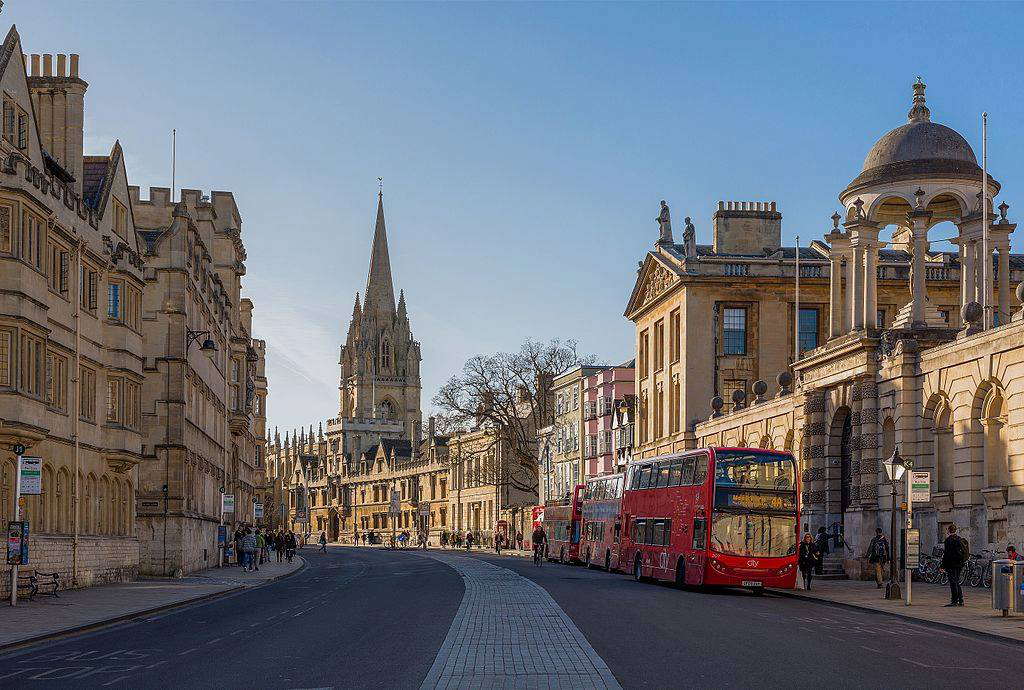

In [9]:
# this is the content image
photo

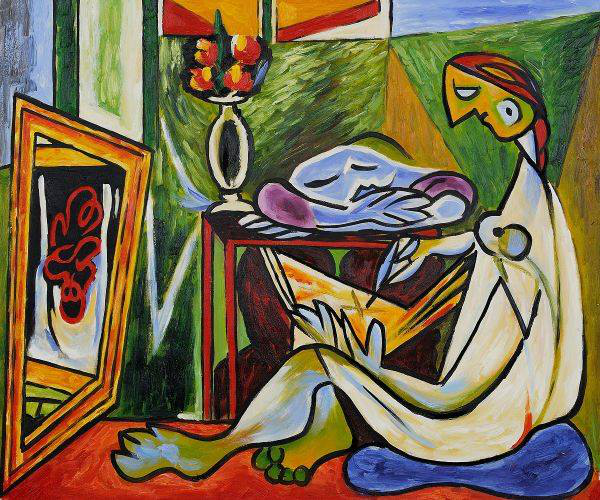

In [10]:
# this is the art image
art

<IPython.core.display.Javascript object>


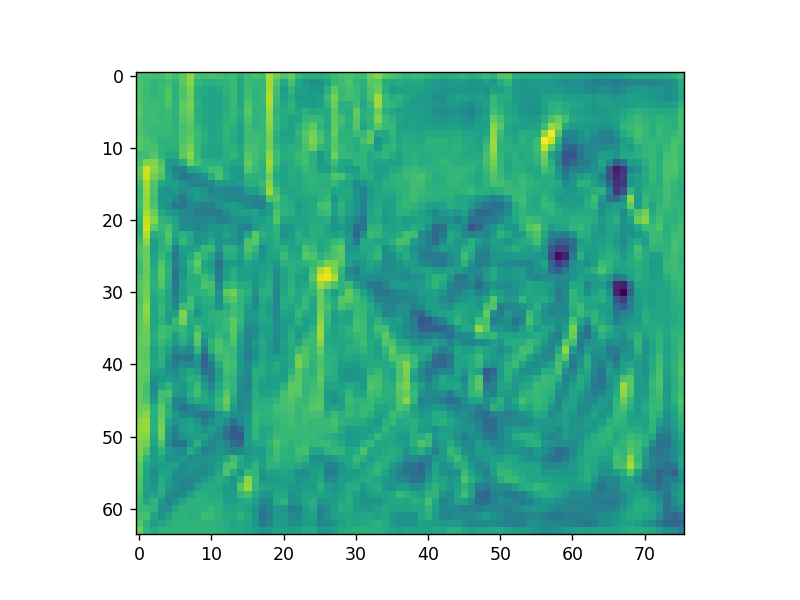

In [11]:
#Visualize various feature representations
tt = net(a)
b = tt['c42'].detach().cpu() # choose layer to pull feature map from
bb = b[0,4,:,:] #2nd axis is different feature map of layer defined above as b = tt['layer']
bb.numpy()
plt.imshow(bb.numpy()) # look at the feature map!

In [12]:
# Initialize the white noise image to be the same dimension as the photo.
h = p.shape[2]
w = p.shape[3]
x = torch.randn(1,3,h,w,requires_grad=True,device='cuda')
losshistory = []

<IPython.core.display.Javascript object>


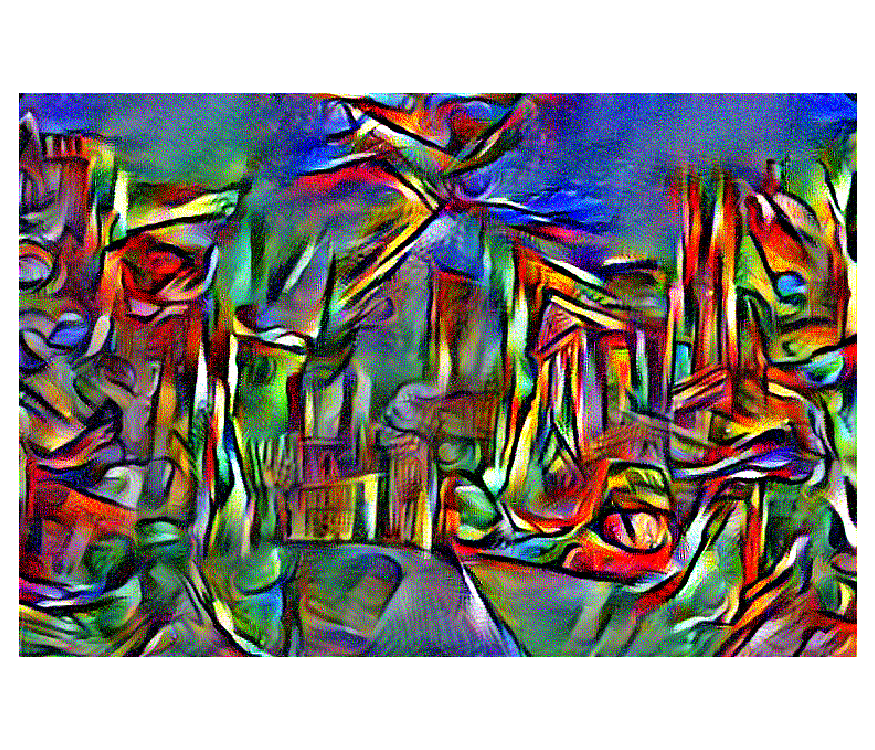

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [14]:
# transfer the style my dude using the Adam optimizer
# if the output is not developed enough, simply run this cell again with the most recently developed output image
# can run 500 epochs at a time until you see something nice (around 3-4 times maybe more)

epochs = 500
styleweight = 6e7 # toggle this to your pleasure

optimizer = torch.optim.Adam([x], lr=0.01, betas=(0.9, 0.999))

# get content representation of content image
P = net.forward(p)
P42NL = P['r42'].shape[1]
P42 = P['r42'].view(P42NL,-1)

# get feature representation of style image
A = net.forward(a) 
A1 = A['r11'].view(64,-1)
A2 = A['r21'].view(128,-1)
A3 = A['r31'].view(256,-1)
A4 = A['r41'].view(512,-1)
A5 = A['r51'].view(512,-1)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))


for epoch in range(epochs):
    optimizer.zero_grad()

    # get feture representations of output image for losses
    outputs = net.forward(x)

    out42 = outputs['r42'].view(P42NL, -1)

    out1 = outputs['r11'].view(64,-1)
    out2 = outputs['r21'].view(128,-1)
    out3 = outputs['r31'].view(256,-1)
    out4 = outputs['r41'].view(512,-1)
    out5 = outputs['r51'].view(512,-1)

    #get content loss
    contentloss = net.criterion(out42,P42)/2

    #get x gram matrices
    gram1 = Gram(out1)
    gram2 = Gram(out2)
    gram3 = Gram(out3)
    gram4 = Gram(out4)
    gram5 = Gram(out5)
    
    #get art gram matrices
    gram1o = Gram(A1)
    gram2o = Gram(A2)
    gram3o = Gram(A3)
    gram4o = Gram(A4)
    gram5o = Gram(A5)

    #style loss from grams
    E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * net.criterion(gram1,gram1o)
    E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * net.criterion(gram2,gram2o)
    E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * net.criterion(gram3,gram3o)
    E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * net.criterion(gram4,gram4o)
    E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * net.criterion(gram5,gram5o)

    #total style loss
#         styleloss = E1*1e3/(64**2) + E2*1e3/(128**2) + E3*1e3/(256**2) + E4*1e3/(512**2) + E5*1e3/(512**2)
    styleloss = (E1+E2+1*E3+E4+E5)/5

    #get total loss
    loss = contentloss + styleweight*styleloss

    #backprop
    loss.backward(retain_graph=True)

    #parameter search
    optimizer.step()
    
    #display during optimization. watch it come to life
    if epoch % 10 == 0:
        lo = loss.detach().cpu()
        losshistory.append(lo)
#         print('loss',loss)
        print(epoch)
        axes.clear()
        xx = x.detach().cpu()
        hh = x.shape[2]
        xx = xx.view(3,h,-1)
        myimshow(xx)
    plt.tight_layout()
    fig.canvas.draw()

#     return x

In [226]:
# plot the loss over epochs for most recent run

# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))
# axes.plot(losshistory)
# plt.ylabel('Loss')
# plt.xlabel('Epochs (10) ')
# plt.savefig('gatys_adam_60000000_loss.png')

<IPython.core.display.Javascript object>


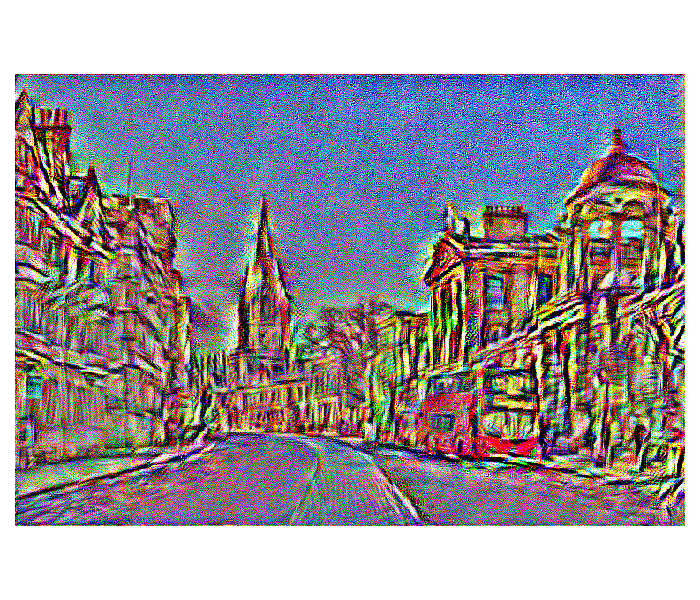

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [227]:
# transfer the style my dude for LBFGS optimizer
# if the output is not developed enough, simply run this cell again with the most recently developed output image

epochs = 500
styleweight = 6e7 # toggle this to your pleasure

optimizer = torch.optim.LBFGS([x], lr=0.01)

# get content representation of content image
P = net.forward(p)
P42NL = P['r42'].shape[1]
P42 = P['r42'].view(P42NL,-1)

# get feature representations of art image
A = net.forward(a) 
A1 = A['r11'].view(64,-1)
A2 = A['r21'].view(128,-1)
A3 = A['r31'].view(256,-1)
A4 = A['r41'].view(512,-1)
A5 = A['r51'].view(512,-1)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

for epoch in range(epochs):
    def closure():
        optimizer.zero_grad()

        # run output image through vgg and get feature representations for losses
        outputs = net.forward(x)

        out42 = outputs['r42'].view(P42NL, -1)

        out1 = outputs['r11'].view(64,-1)
        out2 = outputs['r21'].view(128,-1)
        out3 = outputs['r31'].view(256,-1)
        out4 = outputs['r41'].view(512,-1)
        out5 = outputs['r51'].view(512,-1)

        #get content loss
        contentloss = net.criterion(out42,P42)/2

        #get style gram matrices
        gram1 = Gram(out1)
        gram2 = Gram(out2)
        gram3 = Gram(out3)
        gram4 = Gram(out4)
        gram5 = Gram(out5)

        gram1o = Gram(A1)
        gram2o = Gram(A2)
        gram3o = Gram(A3)
        gram4o = Gram(A4)
        gram5o = Gram(A5)

        #style loss from grams
        E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * net.criterion(gram1,gram1o)
        E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * net.criterion(gram2,gram2o)
        E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * net.criterion(gram3,gram3o)
        E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * net.criterion(gram4,gram4o)
        E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * net.criterion(gram5,gram5o)

        #total style loss
        #styleloss = E1*1e3/(64**2) + E2*1e3/(128**2) + E3*1e3/(256**2) + E4*1e3/(512**2) + E5*1e3/(512**2)
        styleloss = (E1+E2+E3+E4+E5)/5

        #get total loss
        loss = contentloss + styleweight*styleloss
        
        #backprop
        loss.backward(retain_graph=True)
        return loss

    

    #parameter search
    optimizer.step(closure)
    
    #display during optimization
    if epoch % 10 == 0:
        lo = closure().detach().cpu()
        losshistory.append(lo)
#         print(closure()) # print loss
        print(epoch)
        axes.clear()
        xx = x.detach().cpu()
        hh = x.shape[2]
        xx = xx.view(3,h,-1)
        myimshow(xx)
    plt.tight_layout()
    fig.canvas.draw()

#     return x

<IPython.core.display.Javascript object>


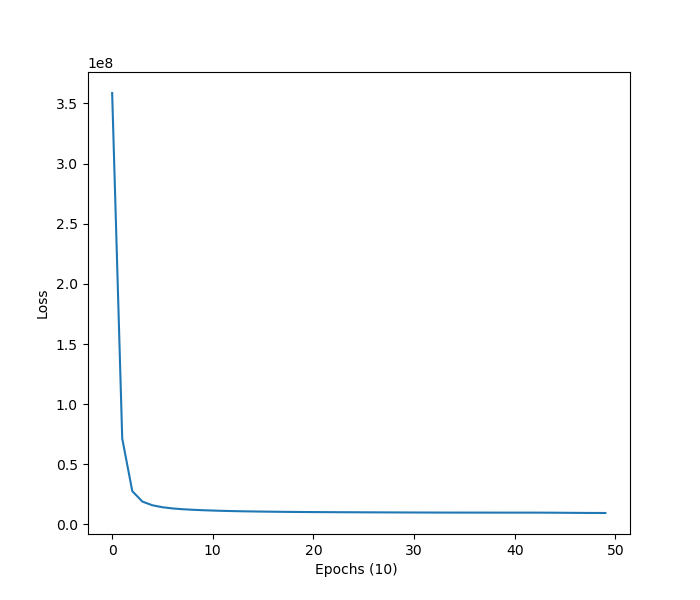

In [222]:
# visualize the loss over epochs of most recent run
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))
axes.plot(losshistory)
plt.ylabel('Loss')
plt.xlabel('Epochs (10) ')
# plt.savefig('gatys_LBFGS_6e7_loss.png')

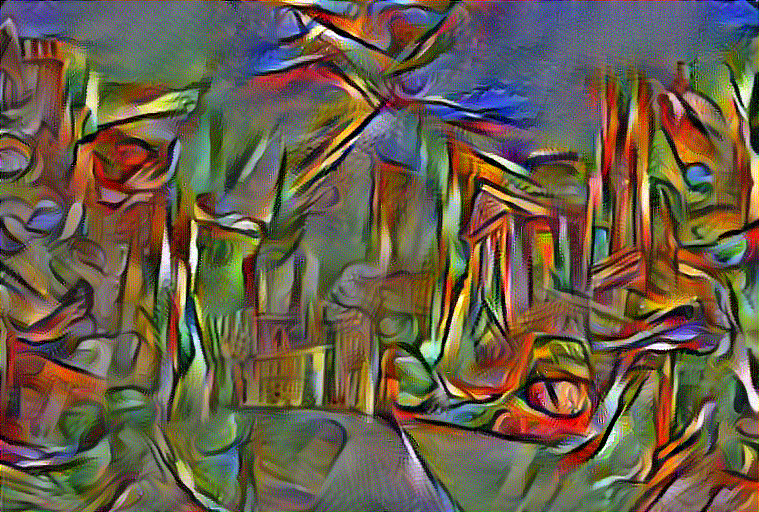

In [16]:
# Inverse normalize the output image to save
x_noncuda = x.detach()
x_noncuda = invtrans(x_noncuda[0])
x_noncuda[x_noncuda>1] = 1
x_noncuda[x_noncuda<0] = 0
x_noncuda_pil = tv.transforms.ToPILImage()(x_noncuda.cpu())
# x_noncuda_pil.save("gatys_LBFSG_6e5.jpg")
x_noncuda_pil